In [1]:
# coding: utf-8

# In[1]:

import numpy as np
#import h5py
#import tensorflow as tf
#import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.layers import Input,Conv2D,Concatenate,Flatten,Dense,LeakyReLU,Dropout, ReLU
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.python.keras.models import Model


from tensorflow.python.keras import backend as K

from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint

from sklearn.model_selection import train_test_split

#from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
#from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.python.keras.models import Sequential
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
fn = 2
d_min = 1
d_max = 10
blur_filter_size = 11
blur_range = 10
image_size = 512
epochs = 50
batch_size = 28

In [3]:
# train_data_path = 'train_data_uint8_512_10000_vcm_alpha.npy'
# test_data_path = 'real_data_uint8_512_vcm_10000_alpha.npy'
# train_label_path = 'train_label_uint8_512_10000_vcm_alpha.npy'
# test_label_path = 'real_label_uint8_512_vcm_10000_alpha.npy'

train_data_path = 'train_data_8000.npy'
test_data_path = 'real_data_uint8_512_vcm_10000_alpha.npy'
train_label_path = 'train_label_8000.npy'
test_label_path = 'real_label_uint8_512_vcm_10000_alpha.npy'

In [4]:
train_data = np.load(train_data_path)
test_data = np.load(test_data_path)
train_label = np.load(train_label_path)
test_label = np.load(test_label_path)

In [ ]:
print(train_data.shape)
print(train_label.shape)
test_data = test_data[1::2, :, :, :]
test_label = test_label[1::2, :]

(8000, 512, 512, 1)
(8000, 2)


[1.    1.051]
uint8


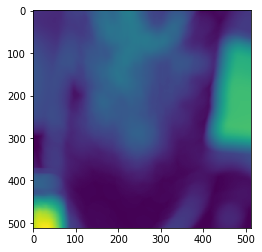

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
idx = 7
plt.imshow(train_data[idx, :, :, 0].astype(np.float32))
print(train_label[idx, :])
print(train_data.dtype)
# batch_features = np.zeros((image_size//2, image_size//2, 4))
# batch_features[:, :, 0] = train_data[idx, 1::2, ::2, 0]
# batch_features[:, :, 1] = train_data[idx, ::2, ::2, 0]
# batch_features[:, :, 2] = train_data[idx, 1::2, 1::2, 0]
# batch_features[:, :, 3] = train_data[idx, ::2, 1::2, 0]
# plt.imshow(batch_features[:, :, 3]*16383)

[1.         0.94598269 0.        ]


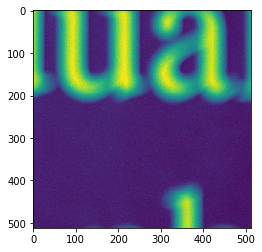

In [ ]:
plt.imshow(test_data[idx, :, :, 0])
print(test_label[idx, :])

In [ ]:
# In[7]:
input_image1 = Input(shape=(512, 512, 1), name = "input")
#layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=None,use_bias=False,kernel_initializer = my_init,trainable=True,name='layer1')(input_image1)
#layer0_1 = Conv2D(4, (1, 1), 1,padding='valid',activation=relu, name="Conv0_1")(input_image1)
layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=relu, name="Conv1_1")(input_image1)
#layer1_1 = LeakyReLU(0.1)(layer1_1)

layer2_1 = Conv2D(8, (4, 4), 4,padding='valid',activation=relu, name="Conv2_1")(layer1_1)
#layer2_1 = LeakyReLU(0.1)(layer2_1)

layer3_1 = Conv2D(8, (4, 4), 4,padding='valid',activation=relu, name="Conv3_1")(layer2_1)
#layer3_1 = LeakyReLU(0.1)(layer3_1)


flattened = Flatten(name="flat")(layer3_1)
dense1 = Dense(1024, name="d1")(flattened)
ReLU1 = LeakyReLU(0.1, name="lr1")(dense1)
#dp1 = Dropout(0.5)(ReLU1)

dense2 = Dense(512, name="d2")(ReLU1)
ReLU2 = LeakyReLU(0.1, name="lr2")(dense2)
#dp2 = Dropout(0.5)(ReLU2)

dense3 = Dense(10, name="d3")(ReLU2)
ReLU3 = LeakyReLU(0.1, name="lr3")(dense3)
#dp3 = Dropout(0.5)(ReLU3)

output_position = Dense(1, name="out")(ReLU3)
print(output_position)

model = Model(inputs=input_image1, outputs=output_position)
model.summary()

tcbc = TensorBoard(log_dir='1')

filepath="models/gen/n_{epoch:03d}-{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='max',period=2)

print(model.output_shape)

Tensor("out/BiasAdd:0", shape=(?, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, 512, 1)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 64, 64, 4)         260       
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 16, 16, 8)         520       
_________________________________________________________________
Conv3_1 (Conv2D)             (None, 4, 4, 8)           1032      
_________________________________________________________________
flat (Flatten)               (None, 128)               0         
_________________________________________________________________
d1 (Dense)                   (None, 1024)              132096    
_________________________________________________________________
lr1 (LeakyReLU)        

In [ ]:
def data_gen(features, labels, batch_size):
    while True:
        for i in np.arange(0, features.shape[0] - batch_size, batch_size):
            # choose random index in features
            ################!!!
#             batch_features = np.zeros((batch_size, image_size, image_size, 1))
#             batch_features[:, :, :, 0] = features[i:i+batch_size, 1::2, ::2, 0]
#             batch_features[:, :, :, 1] = features[i:i+batch_size, ::2, ::2, 0]
#             batch_features[:, :, :, 2] = features[i:i+batch_size, 1::2, 1::2, 0]
#             batch_features[:, :, :, 3] = features[i:i+batch_size, ::2, 1::2, 0]
            batch_features = features[i:i+batch_size, :, :, :]
            batch_features = batch_features.astype('float16')/255.0###########################
            batch_labels = abs(labels[i:i+batch_size, 1:2] - labels[i:i+batch_size, :1])*100
            yield (batch_features, batch_labels)

In [ ]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001)
model.compile(loss='mse', optimizer='Adam')

X_train, X_test, y_train, y_test = train_test_split(
    train_data, train_label, test_size=0.2, random_state=2233)

# model.fit(train_data[:,:,:,0:1].astype('float16')/255.0, abs(train_label[:,1:2]-train_label[:,0:1])/100, 
#           epochs = 100,batch_size = batch_size, #validation_split=0.2,
#           validation_data=(test_data[:,:,:,0:1].astype('float16')/255.0, abs(test_label[:,1:2]-test_label[:,0:1])/100), 
#           verbose=1, callbacks = [tcbc, checkpoint])
model.fit_generator(data_gen(X_train, y_train, batch_size), 
                    steps_per_epoch = X_train.shape[0]/batch_size, epochs = epochs,
                    validation_data=data_gen(X_test, y_test, batch_size), 
                    validation_steps = batch_size,verbose=1)#, callbacks = [tcbc, checkpoint])

Epoch 1/50
229/228 [==============================] - 21s 93ms/step - loss: 5.5717 - val_loss: 3.7233
Epoch 2/50
229/228 [==============================] - 20s 87ms/step - loss: 1.9057 - val_loss: 1.7793
Epoch 3/50
229/228 [==============================] - 20s 87ms/step - loss: 1.4449 - val_loss: 1.5107
Epoch 4/50
229/228 [==============================] - 20s 87ms/step - loss: 1.3255 - val_loss: 1.3663
Epoch 5/50
229/228 [==============================] - 20s 87ms/step - loss: 1.2245 - val_loss: 1.1062
Epoch 6/50
229/228 [==============================] - 20s 88ms/step - loss: 1.0982 - val_loss: 0.9616
Epoch 7/50
229/228 [==============================] - 20s 88ms/step - loss: 1.0463 - val_loss: 1.0229
Epoch 8/50
229/228 [==============================] - 20s 87ms/step - loss: 0.9665 - val_loss: 0.9348
Epoch 9/50
229/228 [==============================] - 20s 88ms/step - loss: 0.9299 - val_loss: 0.9204
Epoch 10/50
229/228 [==============================] - 20s 87ms/step - loss: 0.911

In [ ]:
# model.save('my_model_512.h5')

In [ ]:
# print(train_label[:, :10])

In [ ]:
# from tensorflow.python.keras.models import load_model
# model = load_model('models/050-0.65.hdf5')

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# idxx = 89
# plt.imshow(test_data[idxx, :, :, 0])
# print(test_label[idxx, :])

In [ ]:
# model.predict(test_data[idxx:idxx+1, :, :, :1]/255.0)

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# for i in range(2000//64-1): #
#     test_pred = model.predict(test_data[64*i:64*i+64, :, :, :1]/255.0)
#     test_pred[test_pred<0]= 0
#     plt.scatter(abs(test_label[64*i:64*i+64, 0] - test_label[64*i:64*i+64, 1]), test_pred[:, 0]/100 - abs(test_label[64*i:64*i+64, 0] - test_label[64*i:64*i+64, 1]), color='black', s = 0.1)
# plt.show()
# for i in range(8000//64-1): #
#     train_pred = model.predict(train_data[64*i:64*i+64, :, :, :1]/255.0)
#     train_pred[train_pred<0]= 0
#     plt.scatter(abs(train_label[64*i:64*i+64, 0] - train_label[64*i:64*i+64, 1]), train_pred[:, 0]/100 - abs(train_label[64*i:64*i+64, 0] - train_label[64*i:64*i+64, 1]), color='black', s = 0.1)
# plt.show()

In [ ]:
# test_pred[test_pred<0]= 0
# print(test_pred[:, 0])

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.imshow(test_data[0, :, :, 0])
# print(test_label)

In [ ]:
# plt.scatter(abs(test_label[:, 0] - test_label[:, 1]), test_pred[:, 0])

In [ ]:
print(train_data.dtype)